# 1. Reconstrução e análise do grafo bipartido de autores e proposições


Neste notebook, vamos fazer uma extração dos dados do DuckDB para reconstruir o grafo de autoria de forma a atender as necessidades desta fase de análise. Vamos também fazer uma validação de arestas e vértices, exclusão de órfãos, e estabelecer arestas de equivalência entre objetos que são representados por mais de um vértice (p. ex. um projeto de lei que tenha passado tanto pela Câmara quanto pelo Senado).

Ao fim, vamos gerar um novo par de arquivos CSV com os vértices e arestas.


## 1.1. Imports

In [ ]:
import os

from pathlib import Path
from collections import Counter

import duckdb
import igraph as ig
import Levenshtein as lv
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from utils import build_graph

from dotenv import load_dotenv

load_dotenv()

sns.set_style("darkgrid")

PROJECT_DIR = Path("~/tramita").expanduser()
DB_PATH = PROJECT_DIR / os.getenv("SILVER_DUCKDB_PATH", "")
OUT_DIR = PROJECT_DIR / "gold" / "outputs"
OUT_DIR.mkdir(exist_ok=True)
ACCESS_DIR = PROJECT_DIR / "gold" / "accessory_data"
ACCESS_DIR.mkdir(exist_ok=True)

NODES_PATH_CSV = OUT_DIR / "nodes.csv"
EDGES_PATH_CSV = OUT_DIR / "edges.csv"

## 1.2. Construção de nós e arestas

### 1.2.1. Leitura do banco de dados

Aqui vamos consumir do banco de dados que construímos na fase silver, com alguns ajustes e correções para montar os grafos.

In [2]:
with duckdb.connect(DB_PATH, read_only=True) as con:

    house_props_df = con.execute("SELECT * FROM proposicoes_camara").df().set_index('id_proposicao', drop=True)
    house_autores_df = con.execute("SELECT * FROM autores_camara").df().set_index('id_autor', drop=True)
    house_deputados_df = con.execute("SELECT * FROM deputados_camara").df().set_index('id_deputado', drop=True)
    house_orgaos_df = con.execute("SELECT * FROM orgaos_camara").df().set_index('id_orgao', drop=True)
    house_partidos_df = con.execute("SELECT * FROM partidos_camara").df()
    house_partidos_membros_df = con.execute("SELECT * FROM partidos_membros_camara").df()

    senate_procs_df = con.execute("SELECT * FROM processo_senado").df().set_index('id_processo', drop=True)
    senate_autores_df = con.execute("SELECT * FROM autoria_iniciativa_senado").df().set_index('id_autoria_iniciativa', drop=True)
    senate_parlamentares_df = con.execute("SELECT * FROM parlamentar_senado").df().set_index('codigo_parlamentar', drop=True)
    senate_entes_df = con.execute("SELECT * FROM ente_senado").df().set_index('id_ente', drop=True)
    
    bill_match_df = con.execute("SELECT * FROM correspondencia_proposicoes_processo").df()

senate_parlamentares_df['tag'] = 'SS:' + senate_parlamentares_df.index.astype(str)


Aqui atribuímos aos senadores as tags conforme havia sido feito com as demais tabelas:

| Fonte | Entidade | Tag | Exemplo |
| --- | --- | --- | --- |
| Camara | Deputado | `CD` | `CD:12345` | 
| Camara | Órgão | `CO` | `CO:12345` | 
| Camara | Proposição | `CP` | `CP:12345` | 
| Senado | Senador | `SS` | `SS:12345` | 
| Senado | Ente | `SE` | `SE:12345` | 
| Senado | Processo | `SP` | `SP:12345` | 

Em todos os casos, o número após os dois-pontos corresponde à ID original na API, exceto em casos que serão vistos abaixo.

### 1.2.2. Filtragem 

Removemos da tabela de autorias as entradas que não têm proposições ou processos listados nas respectivas tabelas.

In [3]:
house_autores_df = house_autores_df[
    house_autores_df['id_proposicao'].isin(house_props_df.index)
].copy()

senate_autores_df = senate_autores_df[
    senate_autores_df['id_processo'].isin(senate_procs_df.index)
].copy()

Da mesma forma, podemos eliminar deputados e órgãos e senadores não contemplados nas autorias

In [4]:
house_deputados_df = house_deputados_df[house_deputados_df.index.isin(
    house_autores_df[
        house_autores_df['tipo_autor'].eq('deputados')
    ]['id_deputado_ou_orgao'].unique()
)].copy()

house_orgaos_df = house_orgaos_df[house_orgaos_df.index.isin(
    house_autores_df[
        house_autores_df['tipo_autor'].eq('orgaos')
    ]['id_deputado_ou_orgao'].unique()
)].copy()

senate_parlamentares_df = senate_parlamentares_df[senate_parlamentares_df.index.isin(
    senate_autores_df['codigo_parlamentar'].unique()
)].copy()

Na tabela de autorias do Senado temos uma peculiaridade - embora o modelo `ente` exista para representar instituições e cada tenha uma chave única númerica, na tabela de autorias essa chave não é utilizada. De fato, os entes são referenciados apenas por sigla e nome. E em alguns casos, a sigla é ausente:

In [5]:
senate_autores_df[['ente', 'sigla_ente']].drop_duplicates()

,ente,sigla_ente
id_autoria_iniciativa,,
1955,Senado Federal,SF
6697,Câmara dos Deputados,CD
7052,Comissão de Direitos Humanos e Legislação Part...,CDH
7271,Presidência da República,PR
7735,Comissão de Meio Ambiente,CMA
7773,Superior Tribunal de Justiça,None
7845,Procuradoria-Geral da República,None
18634,Forum Nacional de Comitês Hidrográficas Brasil,CBHS
18735,Tribunal de Justiça do Distrito Federal e Terr...,TJDFT


Isso torna necessário buscar esses entes por sigla na tabela de entes do Senado. Cabe lembrar que essa é a tabela completa de entes, disponibilizada pela API em uma única chamada.


In [6]:
missing_entes_df = senate_autores_df[
    senate_autores_df['sigla_ente'].isnull()
][['ente', 'sigla_tipo', 'descricao_tipo']].drop_duplicates()
missing_entes_df

,ente,sigla_tipo,descricao_tipo
id_autoria_iniciativa,,,
7773,Superior Tribunal de Justiça,TRIBUNAL_SUPERIOR,TRIBUNAL_SUPERIOR
7845,Procuradoria-Geral da República,PROCURADOR_GERAL,PROCURADOR_GERAL
19297,Ministério Público da União,MINISTERIO_PUBLICO_UNIAO,MINISTERIO_PUBLICO_UNIAO
20162,Comissão de Turismo,COMISSAO_CAMARA,COMISSAO_CAMARA
21463,Defensoria Pública da União,DEFENSOR_GERAL,DEFENSOR_GERAL
25416,Comissão especial destinada a acompanhar as aç...,COMISSAO_CAMARA,COMISSAO_CAMARA


Alguns são apenas comissões da Câmara. Vamos substituir pelo ente da Câmara na base do Senado.

In [7]:
house_entes_in_senate = missing_entes_df[missing_entes_df['sigla_tipo'] == "COMISSAO_CAMARA"]
house_entes_in_senate

,ente,sigla_tipo,descricao_tipo
id_autoria_iniciativa,,,
20162,Comissão de Turismo,COMISSAO_CAMARA,COMISSAO_CAMARA
25416,Comissão especial destinada a acompanhar as aç...,COMISSAO_CAMARA,COMISSAO_CAMARA


In [8]:
senate_entes_df.loc[2]

sigla                               CD
nome              Câmara dos Deputados
casa                                CD
sigla_tipo            CASA_LEGISLATIVA
descricao_tipo        Casa Legislativa
data_inicio        1960-01-01 00:00:00
data_fim                           NaT
tag                               SE:2
Name: 2, dtype: object

In [9]:
for index, row in senate_autores_df[senate_autores_df['sigla_tipo'].eq("COMISSAO_CAMARA")].iterrows():
    senate_autores_df.at[index, 'ente'] = "Câmara dos Deputados"
    senate_autores_df.at[index, 'sigla_ente'] = "CD"
    senate_autores_df.at[index, 'sigla_tipo'] = "CASA_LEGISLATIVA"

E eliminamos as comissões da DF de entes faltantes:

In [10]:
missing_entes_df

,ente,sigla_tipo,descricao_tipo
id_autoria_iniciativa,,,
7773,Superior Tribunal de Justiça,TRIBUNAL_SUPERIOR,TRIBUNAL_SUPERIOR
7845,Procuradoria-Geral da República,PROCURADOR_GERAL,PROCURADOR_GERAL
19297,Ministério Público da União,MINISTERIO_PUBLICO_UNIAO,MINISTERIO_PUBLICO_UNIAO
20162,Comissão de Turismo,COMISSAO_CAMARA,COMISSAO_CAMARA
21463,Defensoria Pública da União,DEFENSOR_GERAL,DEFENSOR_GERAL
25416,Comissão especial destinada a acompanhar as aç...,COMISSAO_CAMARA,COMISSAO_CAMARA


In [11]:
missing_entes_df = missing_entes_df[~missing_entes_df['ente'].str.startswith("Comissão")]
missing_entes_df


,ente,sigla_tipo,descricao_tipo
id_autoria_iniciativa,,,
7773,Superior Tribunal de Justiça,TRIBUNAL_SUPERIOR,TRIBUNAL_SUPERIOR
7845,Procuradoria-Geral da República,PROCURADOR_GERAL,PROCURADOR_GERAL
19297,Ministério Público da União,MINISTERIO_PUBLICO_UNIAO,MINISTERIO_PUBLICO_UNIAO
21463,Defensoria Pública da União,DEFENSOR_GERAL,DEFENSOR_GERAL


Vamos criar pseudo-entradas os entes que não foram encontrados. Adotamos numeração a partir de 9999990 para garantir que não colida com nenhum existente.

In [12]:
nomes_e_siglas = {
    'Superior Tribunal de Justiça': '_STJ', 
    'Procuradoria-Geral da República': '_PGR',
    'Ministério Público da União': '_MPU',
    'Defensoria Pública da União': '_DPU',
}
# para cada uma das autorias faltantes, vamos criar novas linhas em senate_entes_df
# preservando id_ente como índice
k = 0
new_rows = []
new_index = []

# Vamos limpar a tabela original para facilitar a concatenação
senate_entes_df = senate_entes_df.drop(["data_inicio", "data_fim"], axis=1).fillna("")

for idx, row in missing_entes_df.iterrows():
    sigla = nomes_e_siglas.get(row['ente'])
    new_id = 9999990 + k
    new_row = {
        'sigla': sigla,
        'nome': row['ente'],
        'casa': "",
        'sigla_tipo': row['sigla_tipo'],
        'descricao_tipo': row['descricao_tipo'],
        'tag': f'SE:{new_id}'
    }
    new_rows.append(new_row)
    new_index.append(new_id)
    k += 1

if new_rows:
    new_df = pd.DataFrame(new_rows, index=new_index)
    # manter o nome do índice (esperado: 'id_ente')
    new_df.index.name = senate_entes_df.index.name
    # concatenar preservando os índices
    senate_entes_df = pd.concat([senate_entes_df, new_df], axis=0)

In [13]:
senate_entes_df

,sigla,nome,casa,sigla_tipo,descricao_tipo,tag
id_ente,,,,,,
7378493,,1ª Câmara de Coordenação e Revisão -Direitos S...,,ENTE_JURIDICO,Ente Jurídico - não categorizado,SE:7378493
7378350,,1ª Câmara de Coordenação e Revisão do Ministér...,,ENTE_JURIDICO,Ente Jurídico - não categorizado,SE:7378350
301,,1º Vice-Presidente da Mesa do Congresso Nacion...,,ENTE_JURIDICO,Ente Jurídico - não categorizado,SE:301
7376109,,"2ª Vara Cível, Família e Sucessões Inf. e Juve...",,ENTE_JURIDICO,Ente Jurídico - não categorizado,SE:7376109
7376147,,"2ª Vara de Família, Sucessões, Órfãos, Interdi...",,ENTE_JURIDICO,Ente Jurídico - não categorizado,SE:7376147
...,...,...,...,...,...,...
7371615,,tribunal de contas da união,,ENTE_JURIDICO,Ente Jurídico - não categorizado,SE:7371615
9999990,_STJ,Superior Tribunal de Justiça,,TRIBUNAL_SUPERIOR,TRIBUNAL_SUPERIOR,SE:9999990
9999991,_PGR,Procuradoria-Geral da República,,PROCURADOR_GERAL,PROCURADOR_GERAL,SE:9999991


Como a tabela de autorias do Senado lista os entes por sigla e não por id, agora preenchemos os ids na tabela de autorias.

In [14]:
senate_autores_df

,id_processo,codigo_parlamentar,descricao_tipo,ente,ordem,outros_autores_nao_informados,sigla_ente,sigla_tipo,year_snapshot
id_autoria_iniciativa,,,,,,,,,
1955,7711601,5627,SENADOR,Senado Federal,2,Não,SF,SENADOR,2019
1956,7711690,5411,SENADOR,Senado Federal,29,Não,SF,SENADOR,2019
1957,7712043,5976,SENADOR,Senado Federal,1,Não,SF,SENADOR,2019
1958,7714029,945,SENADOR,Senado Federal,1,Não,SF,SENADOR,2019
1959,7714041,945,SENADOR,Senado Federal,1,Não,SF,SENADOR,2019
...,...,...,...,...,...,...,...,...,...
35695,8730961,6335,SENADOR,Senado Federal,5,Não,SF,SENADOR,2024
35705,8730961,5502,SENADOR,Senado Federal,4,Não,SF,SENADOR,2024
35715,8730961,6341,SENADOR,Senado Federal,3,Não,SF,SENADOR,2024


In [15]:
for index, row in missing_entes_df.iterrows():
    sigla = nomes_e_siglas.get(row['ente'])
    senate_autores_df.loc[
        senate_autores_df['ente'].eq(row['ente']) &
        senate_autores_df['sigla_ente'].isna(),
        'sigla_ente'
    ] = sigla

In [16]:
senate_autores_df

,id_processo,codigo_parlamentar,descricao_tipo,ente,ordem,outros_autores_nao_informados,sigla_ente,sigla_tipo,year_snapshot
id_autoria_iniciativa,,,,,,,,,
1955,7711601,5627,SENADOR,Senado Federal,2,Não,SF,SENADOR,2019
1956,7711690,5411,SENADOR,Senado Federal,29,Não,SF,SENADOR,2019
1957,7712043,5976,SENADOR,Senado Federal,1,Não,SF,SENADOR,2019
1958,7714029,945,SENADOR,Senado Federal,1,Não,SF,SENADOR,2019
1959,7714041,945,SENADOR,Senado Federal,1,Não,SF,SENADOR,2019
...,...,...,...,...,...,...,...,...,...
35695,8730961,6335,SENADOR,Senado Federal,5,Não,SF,SENADOR,2024
35705,8730961,5502,SENADOR,Senado Federal,4,Não,SF,SENADOR,2024
35715,8730961,6341,SENADOR,Senado Federal,3,Não,SF,SENADOR,2024


Agora mantemos em senate_entes_df somente o que aparece em senate_autores_df. Ou seja, somente onde senate_entes_df.sigla está em senate_autores_df.sigla_ente

In [17]:

senate_entes_df = senate_entes_df[senate_entes_df['sigla'].isin(
    senate_autores_df['sigla_ente'].unique()
)]



In [18]:
senate_entes_df

,sigla,nome,casa,sigla_tipo,descricao_tipo,tag
id_ente,,,,,,
7352398,CPIPANDEMIA,CPI da Pandemia,SF,COMISSAO_TEMPORARIA,Comissão Temporária,SE:7352398
55226,CDIR,Comissão Diretora,SF,COLEGIADO_LEGISLATIVO,Colegiado Legislativo,SE:55226
55451,CDIR,Comissão Diretora do Senado Federal,SF,COLEGIADO_LEGISLATIVO,Colegiado Legislativo,SE:55451
3947422,CDH,Comissão de Direitos Humanos e Legislação Part...,SF,COMISSAO_PERMANENTE,Comissão Permanente,SE:3947422
3927825,CMA,Comissão de Meio Ambiente,SF,COMISSAO_PERMANENTE,Comissão Permanente,SE:3927825
2,CD,Câmara dos Deputados,CD,CASA_LEGISLATIVA,Casa Legislativa,SE:2
7352682,CBHS,Forum Nacional de Comitês Hidrográficas Brasil,,ENTE_JURIDICO,Ente Jurídico - não categorizado,SE:7352682
55126,PR,Presidência da República,,PODER_EXECUTIVO_FEDERAL,Poder Executivo Federal,SE:55126
1,SF,Senado Federal,SF,CASA_LEGISLATIVA,Casa Legislativa,SE:1


In [19]:


# Se houver duplicadas em sigla_ente, mantemos a primeira ocorrência
senate_entes_df = senate_entes_df.drop_duplicates(subset=['sigla'], keep='first')

In [20]:
senate_entes_df

,sigla,nome,casa,sigla_tipo,descricao_tipo,tag
id_ente,,,,,,
7352398,CPIPANDEMIA,CPI da Pandemia,SF,COMISSAO_TEMPORARIA,Comissão Temporária,SE:7352398
55226,CDIR,Comissão Diretora,SF,COLEGIADO_LEGISLATIVO,Colegiado Legislativo,SE:55226
3947422,CDH,Comissão de Direitos Humanos e Legislação Part...,SF,COMISSAO_PERMANENTE,Comissão Permanente,SE:3947422
3927825,CMA,Comissão de Meio Ambiente,SF,COMISSAO_PERMANENTE,Comissão Permanente,SE:3927825
2,CD,Câmara dos Deputados,CD,CASA_LEGISLATIVA,Casa Legislativa,SE:2
7352682,CBHS,Forum Nacional de Comitês Hidrográficas Brasil,,ENTE_JURIDICO,Ente Jurídico - não categorizado,SE:7352682
55126,PR,Presidência da República,,PODER_EXECUTIVO_FEDERAL,Poder Executivo Federal,SE:55126
1,SF,Senado Federal,SF,CASA_LEGISLATIVA,Casa Legislativa,SE:1
5282726,STF,Supremo Tribunal Federal,,ENTE_JURIDICO,Ente Jurídico - não categorizado,SE:5282726


Finalmente, criamos a coluna id_ente em senate_autores_df a partir de sigla_ente usando senate_entes_lookup_df

In [21]:
senate_entes_lookup_df = senate_entes_df[['sigla']].copy()
senate_entes_lookup_df['id_ente'] = senate_entes_lookup_df.index
senate_entes_lookup_df.set_index('sigla', drop=True, inplace=True)
senate_entes_lookup_df

,id_ente
sigla,
CPIPANDEMIA,7352398
CDIR,55226
CDH,3947422
CMA,3927825
CD,2
CBHS,7352682
PR,55126
SF,1
STF,5282726


In [22]:
senate_autores_df['id_ente'] = senate_autores_df['sigla_ente'].map(senate_entes_lookup_df['id_ente'])

Existe, porém, mais uma inconsistência nos dados:

In [23]:
senate_entes_df.loc[7351348]

sigla                                          TST
nome                   Tribunal Superior Eleitoral
casa                                              
sigla_tipo                           ENTE_JURIDICO
descricao_tipo    Ente Jurídico - não categorizado
tag                                     SE:7351348
Name: 7351348, dtype: object

Vamos descobrir qual é esse Tribunal Superior de Schrödinger.

In [24]:
senate_autores_df[senate_autores_df['id_ente'].eq(7351348)]

,id_processo,codigo_parlamentar,descricao_tipo,ente,ordem,outros_autores_nao_informados,sigla_ente,sigla_tipo,year_snapshot,id_ente
id_autoria_iniciativa,,,,,,,,,,
34731,8756679,<NA>,TRIBUNAL_SUPERIOR,Tribunal Superior do Trabalho,1,Não,TST,TRIBUNAL_SUPERIOR,2024,7351348


In [25]:
senate_procs_df.loc[8756679]

codigo_materia                                                               166291
id_processo_casa_inicial                                                    8756678
identificacao                                                          PL 3467/2024
identificacao_processo_inicial                                         PL 3467/2024
identificacao_externa                                                            {}
ano                                                                            2024
casa_identificadora                                                              SF
sigla_casa_iniciadora                                                            CD
sigla_ente_identificador                                                         SF
descricao_sigla                                                      Projeto de Lei
sigla                                                                            PL
numero                                                                      

Trata-se do [PL 3467/2024](https://www.camara.leg.br/proposicoesWeb/fichadetramitacao?idProposicao=2456727), que trata de cargos vagos do TRT. Atribuição do TST.

In [26]:
senate_entes_df.at[7351348, 'nome'] = "Tribunal Superior do Trabalho"
senate_entes_df.loc[7351348]

sigla                                          TST
nome                 Tribunal Superior do Trabalho
casa                                              
sigla_tipo                           ENTE_JURIDICO
descricao_tipo    Ente Jurídico - não categorizado
tag                                     SE:7351348
Name: 7351348, dtype: object

### 1.2.3. Consolidação de órgaos e entes

Tentamos fazer uma correspondência entre os órgãos da Câmara e os entes do Senado.

Cabe observar que a Câmara tem um órgão para a Presidência da República (id 60) e outro para o Poder Executivo (id 253). Para os propósitos deste trabalho, são indistintos. Neste momento vamos associar ambos ao equivalente do Senado (id 55126) e depois vamos também fundir os da Câmara.

Os pares abaixo foram obtidos mediante inspeção manual das tabelas.

In [27]:
entity_match_df = pd.DataFrame([
    {"id_ente": 2, "id_orgao": 100292},  # Câmara
    {"id_ente": 1, "id_orgao": 78},  # Senado
    {"id_ente": 55126, "id_orgao": 60},  # Presidência
    {"id_ente": 55126, "id_orgao": 253},  # Poder Executivo
    {"id_ente": 5282726, "id_orgao": 80},  # STF
    {"id_ente": 9999990, "id_orgao": 81},  # STJ
    {"id_ente": 7351348, "id_orgao": 275},  # TST
    {"id_ente": 7352253, "id_orgao": 82},  # TCU
    {"id_ente": 55143, "id_orgao": 382},  # TJDFT
    {"id_ente": 9999991, "id_orgao": 101347},  # PGR
    {"id_ente": 9999992, "id_orgao": 57},  # MPU
    {"id_ente": 9999993, "id_orgao": 101131},  # DPU
])
entity_match_df

,id_ente,id_orgao
0,2,100292
1,1,78
2,55126,60
3,55126,253
4,5282726,80
5,9999990,81
6,7351348,275
7,7352253,82
8,55143,382
9,9999991,101347


Verificamos.

In [28]:
senate_entes_df

,sigla,nome,casa,sigla_tipo,descricao_tipo,tag
id_ente,,,,,,
7352398,CPIPANDEMIA,CPI da Pandemia,SF,COMISSAO_TEMPORARIA,Comissão Temporária,SE:7352398
55226,CDIR,Comissão Diretora,SF,COLEGIADO_LEGISLATIVO,Colegiado Legislativo,SE:55226
3947422,CDH,Comissão de Direitos Humanos e Legislação Part...,SF,COMISSAO_PERMANENTE,Comissão Permanente,SE:3947422
3927825,CMA,Comissão de Meio Ambiente,SF,COMISSAO_PERMANENTE,Comissão Permanente,SE:3927825
2,CD,Câmara dos Deputados,CD,CASA_LEGISLATIVA,Casa Legislativa,SE:2
7352682,CBHS,Forum Nacional de Comitês Hidrográficas Brasil,,ENTE_JURIDICO,Ente Jurídico - não categorizado,SE:7352682
55126,PR,Presidência da República,,PODER_EXECUTIVO_FEDERAL,Poder Executivo Federal,SE:55126
1,SF,Senado Federal,SF,CASA_LEGISLATIVA,Casa Legislativa,SE:1
5282726,STF,Supremo Tribunal Federal,,ENTE_JURIDICO,Ente Jurídico - não categorizado,SE:5282726


In [29]:
entity_match_df.join(house_orgaos_df['nome'], on="id_orgao").join(
    senate_entes_df['nome'],
    on="id_ente",
    lsuffix="_camara",
    rsuffix="_senado",
)

,id_ente,id_orgao,nome_camara,nome_senado
0,2,100292,CÂMARA DOS DEPUTADOS,Câmara dos Deputados
1,1,78,Senado Federal,Senado Federal
2,55126,60,Presidência da República,Presidência da República
3,55126,253,Poder Executivo,Presidência da República
4,5282726,80,Supremo Tribunal Federal,Supremo Tribunal Federal
5,9999990,81,Superior Tribunal de Justiça,Superior Tribunal de Justiça
6,7351348,275,Tribunal Superior do Trabalho,Tribunal Superior do Trabalho
7,7352253,82,Tribunal de Contas da União,TCU
8,55143,382,Tribunal de Justiça do Distrito Federal e dos ...,Tribunal de Justiça do Distrito Federal e Terr...
9,9999991,101347,Procuradoria-Geral da República,Procuradoria-Geral da República


Normalizamos.

In [30]:
entity_match_df['ente_tag'] = "SE:" + entity_match_df['id_ente'].astype(str)
entity_match_df['orgao_tag'] = "CO:" + entity_match_df['id_orgao'].astype(str)
entity_match_df = entity_match_df.join(house_orgaos_df['nome'], on="id_orgao")
entity_match_df = entity_match_df.drop(['id_ente', 'id_orgao'], axis=1)
entity_match_df

,ente_tag,orgao_tag,nome
0,SE:2,CO:100292,CÂMARA DOS DEPUTADOS
1,SE:1,CO:78,Senado Federal
2,SE:55126,CO:60,Presidência da República
3,SE:55126,CO:253,Poder Executivo
4,SE:5282726,CO:80,Supremo Tribunal Federal
5,SE:9999990,CO:81,Superior Tribunal de Justiça
6,SE:7351348,CO:275,Tribunal Superior do Trabalho
7,SE:7352253,CO:82,Tribunal de Contas da União
8,SE:55143,CO:382,Tribunal de Justiça do Distrito Federal e dos ...
9,SE:9999991,CO:101347,Procuradoria-Geral da República


Renomeamos as colunas e fundimos o Poder Executivo e a Presidência da República na Câmara

In [31]:
entity_match_df = entity_match_df.drop('nome', axis=1).rename(
    columns={'ente_tag': 'source', 'orgao_tag': 'target'}
)

entity_match_df = pd.concat([
    entity_match_df,
    pd.DataFrame([{
        'source': 'CO:60',  # Presidência da República
        'target': 'CO:253',  # Poder Executivo
    }])
])
entity_match_df

,source,target
0,SE:2,CO:100292
1,SE:1,CO:78
2,SE:55126,CO:60
3,SE:55126,CO:253
4,SE:5282726,CO:80
5,SE:9999990,CO:81
6,SE:7351348,CO:275
7,SE:7352253,CO:82
8,SE:55143,CO:382
9,SE:9999991,CO:101347


### 1.2.4. Extração do partido dos parlamentares

Enquanto no Senado, o partido e a UF já vêm junto com os detalhes de cada parlamentar, na Câmara essa informação deve ser buscada indiretamente. Por algum motivo não conseguimos a totalidade das informações na fase Bronze e Prata, então fazemos agora.

In [32]:
house_deputados_df.join(
    house_partidos_membros_df
        .drop_duplicates('id_deputado', keep='last')
        .set_index('id_deputado', drop=True)[['id_partido']],
    on="id_deputado",
)

,nome_civil,uri,year_snapshot,rn,tag,id_partido
id_deputado,,,,,,
66828,FAUSTO RUY PINATO,https://dadosabertos.camara.leg.br/api/v2/depu...,2020,1,CD:66828,37903.0
73463,OSMAR JOSÉ SERRAGLIO,https://dadosabertos.camara.leg.br/api/v2/depu...,2020,1,CD:73463,NaN
73472,GERVÁSIO JOSÉ DA SILVA,https://dadosabertos.camara.leg.br/api/v2/depu...,2020,1,CD:73472,NaN
73486,DARCI POMPEO DE MATTOS,https://dadosabertos.camara.leg.br/api/v2/depu...,2020,1,CD:73486,36786.0
73545,EUSTÁQUIO LUCIANO ZICA,https://dadosabertos.camara.leg.br/api/v2/depu...,2021,1,CD:73545,NaN
...,...,...,...,...,...,...
220638,ANTONIO CARLOS RODRIGUES,https://dadosabertos.camara.leg.br/api/v2/depu...,2023,1,CD:220638,37906.0
220663,JOSÉ ERIBERTO MEDEIROS DE OLIVEIRA,https://dadosabertos.camara.leg.br/api/v2/depu...,2023,1,CD:220663,36832.0
220684,SEBASTIÃO HENRIQUE DE MEDEIROS,https://dadosabertos.camara.leg.br/api/v2/depu...,2023,1,CD:220684,37903.0


Este foi o código usado para baixar as informações:

In [33]:
# Não temos dados suficientes. Temos que buscar na API

# import httpx
# import asyncio
# import re

# response = httpx.get("https://dadosabertos.camara.leg.br/api/v2/partidos/", params={'dataInicio': '2019-01-01', 'dataFim': '2025-01-01', 'itens': '100'})
# data = response.json()

# pids = [d['id'] for d in data['dados']]


# pat = re.compile(r"&pagina=(\d+)&")

# async def get_membros(sem, client, id_partido):
#     async with sem:
#         all_data = []
#         print(id_partido)
#         for retry in range(10):
#             try:
#                 response = await client.get(
#                     f"https://dadosabertos.camara.leg.br/api/v2/partidos/{id_partido}/membros",
#                     params={'dataInicio': '2019-01-01', 'dataFim': '2025-01-01', 'itens': '15'}
#                 )
#                 response.raise_for_status()
#                 data = response.json()
#                 all_data.extend(data['dados'])
#                 for link in data.get('links', []):
#                     if link.get('rel', '') == 'last':
#                         n_pages = int(pat.findall(link['href'])[0])
#                         break
#                 else:
#                     return all_data
#                 for page in range(2, n_pages + 1):
#                     response = await client.get(
#                         f"https://dadosabertos.camara.leg.br/api/v2/partidos/{id_partido}/membros",
#                         params={'dataInicio': '2019-01-01', 'dataFim': '2025-01-01', 'itens': '15', 'pagina': page}
#                     )
#                     response.raise_for_status()
#                     data = response.json()
#                     all_data.extend(data['dados'])
#                 return all_data
#             except Exception as e:
#                 print(e)
#                 print(f"Retrying {id_partido}...")
#                 await asyncio.sleep(4)
    
# sem = asyncio.Semaphore(4)
# async with httpx.AsyncClient() as client:
#     tasks = [get_membros(sem, client, ip) for ip in pids]
#     result = await asyncio.gather(*tasks)
# partido_rows = []
# for r in result:
#     partido_rows.extend(r)
    
# partido_df = pd.DataFrame(partido_rows)
# partido_df = partido_df.sort_values('idLegislatura').drop_duplicates('id', keep='last').copy()
# partido_df['partido'] = partido_df['siglaPartido'] + "/" + partido_df['siglaUf']
# partido_df.to_pickle(ACCESS_DIR / "partidos_membros_camara.pkl")

In [34]:
partido_df = pd.read_pickle(ACCESS_DIR / "partidos_membros_camara.pkl")

Agregamos então à tabela de deputados os partidos obtidos.

In [35]:
house_deputados_df = house_deputados_df.join(
    partido_df.set_index('id', drop=True)[['partido']],
    on="id_deputado",
)

Mesmo assim, vemos que alguns ficaram faltando.

In [36]:
house_deputados_df.value_counts('partido', dropna=False)

partido
NaN             40
PL/SP           17
PT/SP           14
PL/RJ           12
PSD/RJ          12
                ..
UNIÃO/SC         1
CIDADANIA/BA     1
CIDADANIA/AM     1
UNIÃO/TO         1
AVANTE/AP        1
Name: count, Length: 337, dtype: int64

In [37]:
no_party_deputado_ids = house_deputados_df[house_deputados_df['partido'].isna()].index
no_party_deputado_ids

Index([ 73472,  73545,  74047,  74137,  74218,  74491,  73454, 141548, 160568,
        74162,  74474, 178940,  74389,  74496,  74750, 141386,  73474,  74037,
        73940,  74284, 160623,  74133,  74153,  74780,  74145,  73653,  73764,
        73588,  74391, 131085, 141870, 160597, 160644, 195143,  74274,  74581,
       130398, 160586,  74031,  74124],
      dtype='int64', name='id_deputado')

Podemos obter isso da API da Câmara com o endpoint de históricos

In [38]:
# import httpx
# import asyncio

# sem = asyncio.Semaphore(4)

# async def get_historico_deputado(client, sem, id_deputado):
#     async with sem:
#         print(id_deputado)
#         for retry in range(10):
#             try:
#                 response = await client.get(f"https://dadosabertos.camara.leg.br/api/v2/deputados/{id_deputado}/historico/")
#                 response.raise_for_status()
#                 return response.json()
#             except Exception as e:
#                 print("Exception:", e)
#                 print(f"Retrying {id_deputado}, {retry + 1}/10...")
#                 await asyncio.sleep(5)
            
# async with httpx.AsyncClient() as client:
#     tasks = [get_historico_deputado(client, sem, id) for id in no_party_deputado_ids]
#     result = await asyncio.gather(*tasks)
# historico_deputados_rows = []
# for r in result:
#     historico_deputados_rows.extend(r['dados'])
# historico_deputados_df = pd.DataFrame(historico_deputados_rows)
# historico_deputados_df = historico_deputados_df.sort_values('dataHora')
# historico_deputados_df.to_pickle(ACCESS_DIR / "historico_deputados_camara.pkl")

In [39]:
historico_deputados_df = pd.read_pickle(ACCESS_DIR / "historico_deputados_camara.pkl")

Agora preenchemos os partidos dos deputados que faltam.

In [40]:
house_partido_lookup_df = (
    historico_deputados_df
        .drop_duplicates("id", keep="last")
        .set_index('id', drop=True)[['siglaPartido', 'siglaUf']]
)

def build_partido_column(row: pd.Series) -> str:
    return row['siglaPartido'] + "/" + row['siglaUf']

house_partido_lookup_df['partido'] = house_partido_lookup_df.apply(build_partido_column, axis=1)
house_partido_lookup_df

,siglaPartido,siglaUf,partido
id,,,
130398,UDN,RN,UDN/RN
131085,UDN,MG,UDN/MG
74496,PT,SP,PT/SP
74153,PT,MG,PT/MG
73545,PT,SP,PT/SP
74389,PT,SC,PT/SC
74137,PT,SP,PT/SP
74031,PSOL,CE,PSOL/CE
73454,PT,MS,PT/MS


In [41]:
for index, row in house_deputados_df.iterrows():
    if pd.isna(row['partido']):
        house_deputados_df.at[index, 'partido'] = house_partido_lookup_df.loc[index, 'partido']

In [42]:
def build_partido_column_senado(row: pd.Series) -> str | pd._libs.missing.NAType:
    if pd.isna(row['sigla_partido']) or pd.isna(row['uf_parlamentar']):
        return pd.NA
    return row['sigla_partido'] + "/" + row['uf_parlamentar']

senate_parlamentares_df['partido'] = senate_parlamentares_df.apply(
    build_partido_column_senado,
    axis=1,
)

In [43]:
senator_no_party_ids = senate_parlamentares_df[senate_parlamentares_df['partido'].isna()].index

Para obter os partidos e UFs que faltam dos senadores, precisamos consultar a API para o endpoint dos mandatos, o que não fizemos na fase bronze

In [44]:
# import httpx
# import asyncio

# sen_ids = senator_no_party_ids

# results = []

# async def get_mandato(client, sen_id):
#     response = await client.get(f"https://legis.senado.leg.br/dadosabertos/senador/{sen_id}/mandatos.json")
#     return response.json()
# async with httpx.AsyncClient() as client:
#     for i in range(0, len(sen_ids), 5):
#         tasks = [get_mandato(client, sid) for sid in sen_ids[i:i+5]]
#         result = await asyncio.gather(*tasks)
#         results.extend(result)
#         await asyncio.sleep(2)
    
# ids_and_parties = []
# for i, r in enumerate(results):
#     cod_parlamentar = r['MandatoParlamentar']['Parlamentar']['Codigo']
#     mandatos = r['MandatoParlamentar']['Parlamentar']['Mandatos']['Mandato']
#     mandatos = sorted(mandatos, key=lambda v: v['PrimeiraLegislaturaDoMandato']['DataFim'])
#     ultimo_mandato = mandatos[-1]
#     uf = ultimo_mandato['UfParlamentar']
#     try:
#         partido = ultimo_mandato['Partidos']['Partido'][0]['Sigla']
#     except KeyError:
#         try:
#             partido = ultimo_mandato['Partidos']['Partido']['Sigla']
#         except KeyError:
#             partido = "<AUSENTE>"
#     ids_and_parties.append({
#         'cod_parlamentar': cod_parlamentar,
#         'partido': partido,
#         'uf': uf,
#     })
# senate_ids_and_parties_df = pd.DataFrame(ids_and_parties)
# senate_ids_and_parties_df['cod_parlamentar'] = senate_ids_and_parties_df['cod_parlamentar'].astype(int)
# senate_ids_and_parties_df = senate_ids_and_parties_df.set_index('cod_parlamentar', drop=True)

# # # O único que ficou faltando foi o Tasso Jereissati, que é membro do PSDB desde 1988

# senate_ids_and_parties_df.at[3396, 'partido'] = "PSDB"
# senate_ids_and_parties_df.at[3396, 'uf'] = "CE"
# senate_ids_and_parties_df.to_pickle(ACCESS_DIR / "senate_ids_and_parties_df.pkl")

In [45]:
senate_ids_and_parties_df = pd.read_pickle(ACCESS_DIR / "senate_ids_and_parties_df.pkl")
senate_ids_and_parties_df


,partido,uf
cod_parlamentar,,
5537,PSB,SC
5639,PP,TO
5996,PP,PB
1023,PP,SE
5585,PSC,GO
6363,PL,MT
151,MDB,ES
2331,MDB,ES
5927,PSD,AP


In [46]:
for index, row in senate_parlamentares_df[senate_parlamentares_df['partido'].isna()].iterrows():
    partido = senate_ids_and_parties_df.loc[index, 'partido']
    uf = senate_ids_and_parties_df.loc[index, 'uf']
    senate_parlamentares_df.at[index, 'sigla_partido'] = partido
    senate_parlamentares_df.at[index, 'uf_parlamentar'] = uf
    senate_parlamentares_df.at[index, 'partido'] = partido + "/" + uf
    

### 1.2.5. Construção dos vértices

Agora que temos os dados necessários, criamos e registramos os vértices, concatenando as tabelas, alinhando as colunas de cada uma para que estejam nesta ordem:

* `tag`: O rótulo no formato `AA:12345` conforme estabelecido acima;
* `label`: Alguma identificação legível (ex. "PL 12345/2018", "Josimar das Neves");
* As demais colunas de atributos adicionais que gostaríamos de acessar no grafo.

In [47]:
nodes_df = pd.concat([
    house_props_df[["prop_tag", "prop_label"]].rename(
        columns={"prop_tag": "tag", "prop_label": "label"}
    ),
    house_deputados_df[["tag", "nome_civil", "partido"]].rename(
        columns={"nome_civil": "label"}
    ),
    house_orgaos_df[["tag", "nome"]].rename(
        columns={"nome": "label"}
    ),
    senate_procs_df[["tag", "identificacao"]].rename(
        columns={"identificacao": "label"}
    ),
    senate_parlamentares_df[["tag", "nome_completo", "partido"]].rename(
        columns={"nome_completo": "label"}
    ),
    senate_entes_df[["tag", "nome"]].rename(
        columns={"nome": "label"}
    ),
], ignore_index=True).drop_duplicates().reset_index(drop=True)

# Padronizamos todos os labels em caixa-alta para dar conta de diferenças entre as APIs
nodes_df['label'] = nodes_df['label'].str.upper()

# Criamos uma coluna adicional auxiliar para análise posterior e,
# de quebra, garantimos que todas as linhas estão adequadamente tagueadas.
def get_node_type(tag: str) -> str:
    prefix = tag[:3]
    match prefix:
        case 'CP:':
            return 'Proposicao'
        case 'CD:':
            return 'Deputado'
        case 'CO:':
            return 'Orgao'
        case 'SP:':
            return 'Processo'
        case 'SS:':
            return 'Senador'
        case 'SE:':
            return 'Ente'
        case _:
            raise ValueError(f"Achei tag inválida: {tag}")
    
nodes_df['type'] = nodes_df['tag'].apply(get_node_type)


### 1.2.6. Construção das arestas



#### 1.2.6.1. Arestas de autoria

Primeiramente, na tabela de autoria do Senado, precisamos atribuir cada linha à tag correta de autoria. Note-se que um ente está sempre indicado -- mesmo quando a autoria é de um senador individual, ainda assim está indicado o próprio Senado Federal como ente:

In [48]:
senate_autores_df.sample(10, random_state=42)

,id_processo,codigo_parlamentar,descricao_tipo,ente,ordem,outros_autores_nao_informados,sigla_ente,sigla_tipo,year_snapshot,id_ente
id_autoria_iniciativa,,,,,,,,,,
7406,7818807,5894,SENADOR,Senado Federal,33,Não,SF,SENADOR,2019,1
10282,7900190,2331,SENADOR,Senado Federal,1,Não,SF,SENADOR,2020,1
8110,7868404,3806,SENADOR,Senado Federal,1,Não,SF,SENADOR,2020,1
9315,7848800,5422,SENADOR,Senado Federal,20,Não,SF,SENADOR,2019,1
30146,8494256,<NA>,PRESIDENTE_REPUBLICA,Presidência da República,1,Não,PR,PRESIDENTE_REPUBLICA,2023,55126
4632,7720966,5533,SENADOR,Senado Federal,11,Não,SF,SENADOR,2019,1
10144,7778476,5929,SENADOR,Senado Federal,27,Não,SF,SENADOR,2019,1
8450,7880871,739,SENADOR,Senado Federal,1,Não,SF,SENADOR,2020,1
9237,7784398,825,SENADOR,Senado Federal,22,Não,SF,SENADOR,2019,1


Portanto, separamos as autorias segundo esse critério, também atribuindo as tags corretas aos senadores (`SS`), entes (`SE`) e processos (`SP`), que formarão as extremidades de cada aresta de autoria:

In [49]:
def get_senate_auth_tag(row):
    if row['sigla_ente'] == 'SF' and not pd.isna(row['codigo_parlamentar']):
        return f"SS:{row['codigo_parlamentar']}"
    else:
        return f"SE:{row['id_ente']}"
        
senate_autores_df['proc_tag'] = senate_autores_df['id_processo'].apply(lambda x: f"SP:{x}")
senate_autores_df['auth_tag'] = senate_autores_df.apply(get_senate_auth_tag, axis=1)


In [50]:
senate_edges_df = senate_autores_df.copy()
senate_edges_df.rename(columns={'auth_tag': 'source', 'proc_tag': 'target'}, inplace=True)
senate_edges_df = senate_edges_df[['source', 'target']]
senate_edges_df

,source,target
id_autoria_iniciativa,,
1955,SS:5627,SP:7711601
1956,SS:5411,SP:7711690
1957,SS:5976,SP:7712043
1958,SS:945,SP:7714029
1959,SS:945,SP:7714041
...,...,...
35695,SS:6335,SP:8730961
35705,SS:5502,SP:8730961
35715,SS:6341,SP:8730961


Já na Câmara, precisamos separar os autores que de fato foram proponentes da matéria. Há uma coluna booleana na tabela de autorias indicando se cada autor fora proponente:


In [51]:
house_autores_df['proponente'].value_counts()

proponente
True     44839
False     7023
Name: count, dtype: int64

Filtramos portanto segundo esse critério.

(No caso do Senado, as autorias foram extraídas do campo `autoriaIniciativa`, que entendemos abranger apenas os proponentes da matéria, então esse passo não foi necessário.)

In [52]:
house_edges_df = house_autores_df[house_autores_df['proponente']].copy()

Agora atribuímos a cada autoria a tag correta de autor (seja deputado ou órgão) e da proposição. Disso geramos as arestas de autoria da Câmara.

In [53]:

house_edges_df['prop_label'] = 'CP:' + house_edges_df['id_proposicao'].astype(str)
house_edges_df['auth_label'] = house_edges_df.apply(
    lambda row: (
        f"CD:{row['id_deputado_ou_orgao']}"
        if row['tipo_autor'] == 'deputados'
        else f"CO:{row['id_deputado_ou_orgao']}"
    ),
    axis=1,
)
house_edges_df = house_edges_df[['auth_label', 'prop_label']].rename(
    columns={'auth_label': 'source', 'prop_label': 'target'},
)

Consolidamos as arestas de autoria num único DataFrame, que ainda será complementado com as de correspondência:

In [54]:
edges_df = pd.concat([house_edges_df, senate_edges_df], ignore_index=True)
edges_df['etype'] = 'autoria'
edges_df

,source,target,etype
0,CD:160655,CP:538196,autoria
1,CD:141488,CP:559138,autoria
2,CD:73584,CP:593065,autoria
3,CD:160518,CP:601739,autoria
4,CD:151208,CP:614512,autoria
...,...,...,...
49837,SS:6335,SP:8730961,autoria
49838,SS:5502,SP:8730961,autoria
49839,SS:6341,SP:8730961,autoria
49840,SS:6009,SP:8730961,autoria


#### 1.2.6.2. Arestas de correspondência

Vamos agora gerar as arestas de correspondência entre vértices. Nomeadamente, temos:

* Proposições da Câmara que correspondem a processos no Senado;
* Órgãos da Câmara que equivalem a entes no Senado;
* Deputados e Senadores que ocuparam ambos os cargos;
* Caso especial da Presidência da República na Câmara;
* PEC 10/2020, que fora fracionada em duas fases.

Começamos pelas proposições/processos:

In [55]:
bill_match_df['house_tag'] = 'CP:' + bill_match_df['id_proposicao_camara'].astype(str)
bill_match_df['senate_tag'] = 'SP:' + bill_match_df['id_processo_senado'].astype(str)
bill_match_df


,id_proposicao_camara,id_processo_senado,identificacao,house_tag,senate_tag
0,2190585,8006262,PL 123/2019,CP:2190585,SP:8006262
1,2190598,8311169,PL 130/2019,CP:2190598,SP:8311169
2,2191635,8074610,PL 610/2019,CP:2191635,SP:8074610
3,2192978,7858383,PL 1095/2019,CP:2192978,SP:7858383
4,2193223,8070435,PL 1177/2019,CP:2193223,SP:8070435
...,...,...,...,...,...
1671,2345499,8272922,PL 1604/2022,CP:2345499,SP:8272922
1672,2345500,7872006,PL 509/2020,CP:2345500,SP:7872006
1673,2345555,8356901,MPV 1158/2023,CP:2345555,SP:8356901
1674,2345556,8356907,MPV 1159/2023,CP:2345556,SP:8356907


Mantemos apenas o que de fato consta nos nossos vértices finais:

In [56]:
common_labels = set(nodes_df[nodes_df['type'].eq('Proposicao')]['label']).intersection(
    set(nodes_df[nodes_df['type'].eq('Processo')]['label']),
)
filtered_bill_match_df = bill_match_df[bill_match_df['identificacao'].isin(common_labels)]
filtered_bill_match_df

,id_proposicao_camara,id_processo_senado,identificacao,house_tag,senate_tag
0,2190585,8006262,PL 123/2019,CP:2190585,SP:8006262
1,2190598,8311169,PL 130/2019,CP:2190598,SP:8311169
2,2191635,8074610,PL 610/2019,CP:2191635,SP:8074610
3,2192978,7858383,PL 1095/2019,CP:2192978,SP:7858383
4,2193223,8070435,PL 1177/2019,CP:2193223,SP:8070435
...,...,...,...,...,...
1671,2345499,8272922,PL 1604/2022,CP:2345499,SP:8272922
1672,2345500,7872006,PL 509/2020,CP:2345500,SP:7872006
1673,2345555,8356901,MPV 1158/2023,CP:2345555,SP:8356901
1674,2345556,8356907,MPV 1159/2023,CP:2345556,SP:8356907


In [57]:
filtered_bill_match_df = filtered_bill_match_df[['house_tag', 'senate_tag']].rename(
    columns={'house_tag': 'source', 'senate_tag': 'target'},
)
filtered_bill_match_df['etype'] = 'correspondencia'
filtered_bill_match_df

,source,target,etype
0,CP:2190585,SP:8006262,correspondencia
1,CP:2190598,SP:8311169,correspondencia
2,CP:2191635,SP:8074610,correspondencia
3,CP:2192978,SP:7858383,correspondencia
4,CP:2193223,SP:8070435,correspondencia
...,...,...,...
1671,CP:2345499,SP:8272922,correspondencia
1672,CP:2345500,SP:7872006,correspondencia
1673,CP:2345555,SP:8356901,correspondencia
1674,CP:2345556,SP:8356907,correspondencia


Acrescentamos o caso especial das duas fases da PEC 10/2020:

In [58]:
nodes_df[nodes_df['label'].str.contains("PEC 10/2020")]

,tag,label,partido,type
2039,CP:2242583,PEC 10/2020,NaN,Proposicao
2668,CP:2249946,PEC 10/2020,NaN,Proposicao
28759,SP:7890828,PEC 10/2020,NaN,Processo


In [59]:
filtered_bill_match_df = pd.concat([
    filtered_bill_match_df,
    pd.DataFrame([{'source': 'CP:2242583', 'target': 'CP:2249946', 'etype': 'correspondencia'}])
])

Agora fazemos o mesmo para órgãos (Câmara) e entes (Senado). Já temos a tabela pronta. Preparamos-na para ser concatenada à de arestas.

In [60]:
entity_match_df['etype'] = 'correspondencia'

In [61]:
entity_match_df

,source,target,etype
0,SE:2,CO:100292,correspondencia
1,SE:1,CO:78,correspondencia
2,SE:55126,CO:60,correspondencia
3,SE:55126,CO:253,correspondencia
4,SE:5282726,CO:80,correspondencia
5,SE:9999990,CO:81,correspondencia
6,SE:7351348,CO:275,correspondencia
7,SE:7352253,CO:82,correspondencia
8,SE:55143,CO:382,correspondencia
9,SE:9999991,CO:101347,correspondencia


Agora vamos procurar deputados que viraram senadores e vice-versa.

Para tal, tomamos o produto cartesiano de deputados e senadores e calculamos um índice de semelhança de texto com base na distância Levenshtein.

Para cada nome de deputado $n_d$ e nome de senador $n_s$, com comprimentos respectivos em caracteres $l_d$ e $l_s$, com distância Levenshtein dada como $L(n_d, n_s)$, encontramos a semelhança $s(n_d, n_s)$ como:

$$s(n_d, n_s) = 1 - \frac{L(n_d, n_s)}{\max(l_d, l_s)}$$

Também desconsideramos algumas partículas que porventura podem ser omitidas (como "de", "da" etc.).

Vamos criar um DataFrame para examinar essas semelhanças.

In [62]:
def score_similarity(s1: str, s2: str) -> float:
    stopwords = ('de', 'da', 'do', 'das', 'dos', 'e')
    s1_words = [w for w in s1.lower().split() if w not in stopwords]
    s2_words = [w for w in s2.lower().split() if w not in stopwords]
    s1 = " ".join(s1_words)
    s2 = " ".join(s2_words)
    distance = lv.distance(s1, s2)
    return (1 - distance / max(len(s1), len(s2)))

In [63]:
sim_rows = []
sen_labels = nodes_df[nodes_df['type'].eq('Senador')]['label'].values
sen_tags = nodes_df[nodes_df['type'].eq('Senador')]['tag'].values

dep_labels = nodes_df[nodes_df['type'].eq('Deputado')]['label'].values
dep_tags = nodes_df[nodes_df['type'].eq('Deputado')]['tag'].values

for sl, st in zip(sen_labels, sen_tags):
    for dl, dt in zip(dep_labels, dep_tags):
        sim_rows.append({
            'sen_label': sl,
            'sen_tag': st,
            'dep_label': dl,
            'dep_tag': dt,
            'sim_score': score_similarity(sl, dl),
        })

In [64]:
sim_df = pd.DataFrame(sim_rows).sort_values('sim_score', ascending=False)
sim_df

,sen_label,sen_tag,dep_label,dep_tag,sim_score
30400,MARA CRISTINA GABRILLI,SS:5376,MARA CRISTINA GABRILLI,CD:160565,1.0
11465,MARIA AUXILIADORA SEABRA REZENDE,SS:5386,MARIA AUXILIADORA SEABRA REZENDE,CD:160639,1.0
22594,WELLINGTON ANTONIO FAGUNDES,SS:1173,WELLINGTON ANTONIO FAGUNDES,CD:73653,1.0
71067,EFRAIM DE ARAÚJO MORAIS FILHO,SS:4642,EFRAIM DE ARAÚJO MORAIS FILHO,CD:141422,1.0
61274,ROMARIO DE SOUZA FARIA,SS:5322,ROMARIO DE SOUZA FARIA,CD:160597,1.0
...,...,...,...,...,...
694,LAÉRCIO JOSÉ DE OLIVEIRA,SS:4811,FILIPE MARTINS DOS SANTOS,CD:220545,0.0
92998,OMAR JOSÉ ABDEL AZIZ,SS:5525,LUIZA ERUNDINA DE SOUSA,CD:74784,0.0
63258,TELMÁRIO MOTA DE OLIVEIRA,SS:5535,LUIZ ALBUQUERQUE COUTO,CD:74041,0.0
108877,CLEITON GONTIJO DE AZEVEDO,SS:6337,ARTHUR CÉSAR PEREIRA DE LIRA,CD:160541,0.0


Pelos dados, vemos que podemos selecionar as fileiras onde $s(n_d, n_s) >= 0.95$. São casos de diferenças de uma letra, ou de vogal acentuada.

A partir disso, vamos então criar as arestas de correspondência para desambiguação de parlamentares.

In [65]:
SIM_THRESHOLD = 0.95


In [66]:
congressperson_match_df = sim_df[sim_df['sim_score'].ge(SIM_THRESHOLD)].rename(
    columns={'sen_tag': 'source', 'dep_tag': 'target'}
)[['source', 'target']].reset_index(drop=True)
congressperson_match_df['etype'] = 'correspondencia'

In [67]:
congressperson_match_df

,source,target,etype
0,SS:5376,CD:160565,correspondencia
1,SS:5386,CD:160639,correspondencia
2,SS:1173,CD:73653,correspondencia
3,SS:4642,CD:141422,correspondencia
4,SS:5322,CD:160597,correspondencia
5,SS:5350,CD:160509,correspondencia
6,SS:22,CD:160649,correspondencia
7,SS:5740,CD:178905,correspondencia
8,SS:5736,CD:178901,correspondencia
9,SS:4639,CD:141335,correspondencia


Agora, não sabemos quais deputados viraram senadores e quais senadores viraram deputados. Na dúvida, vamos privilegiar o que ocupou mais tempo no período considerado. Como são só 15 casos, vamos verificar manualmente.

In [68]:
nodes_df.join(
    congressperson_match_df.set_index('source')[['target']],
    on="tag",
    how="right"
)

,tag,label,partido,type,target
30832,SS:5376,MARA CRISTINA GABRILLI,PSD/SP,Senador,CD:160565
30811,SS:5386,MARIA AUXILIADORA SEABRA REZENDE,UNIÃO/TO,Senador,CD:160639
30823,SS:1173,WELLINGTON ANTONIO FAGUNDES,PL/MT,Senador,CD:73653
30876,SS:4642,EFRAIM DE ARAÚJO MORAIS FILHO,UNIÃO/PB,Senador,CD:141422
30865,SS:5322,ROMARIO DE SOUZA FARIA,PL/RJ,Senador,CD:160597
30846,SS:5350,JORGINHO DOS SANTOS MELLO,PL/SC,Senador,CD:160509
30911,SS:22,ESPERIDIÃO AMIN HELOU FILHO,PP/SC,Senador,CD:160649
30885,SS:5740,FABIO PAULINO GARCIA,UNIÃO/MT,Senador,CD:178905
30870,SS:5736,TEREZA CRISTINA CORREA DA COSTA DIAS,PP/MS,Senador,CD:178901
30899,SS:4639,JOSÉ ROBERTO OLIVEIRA FARO,PT/PA,Senador,CD:141335


Convencionamos que `source` será mantido e `target` suprimido. Assim, precisamos inverter quando substituímos um senador pelo deputado. Só encontramos dois casos assim:

In [69]:
row_swaps = [
    'SS:5740',  # Fábio Garcia, foi senador por 4 meses em 2022 por afastamento do titular
    'SS:5902',  # Eduardo Velloso, foi senador por 5 meses em 2022 por afastamento do titular   
]

congressperson_match_df[congressperson_match_df['source'].isin(row_swaps)]

,source,target,etype
7,SS:5740,CD:178905,correspondencia
12,SS:5902,CD:220589,correspondencia


Efetuamos a troca:

In [70]:

for swap_tag in row_swaps:
    mask = (
        congressperson_match_df['etype'].eq('correspondencia')
        & congressperson_match_df['source'].eq(swap_tag)
    )
    swap_values = congressperson_match_df.loc[mask, ['target', 'source']].values
    congressperson_match_df.loc[mask, ['source', 'target']] = swap_values


In [71]:
congressperson_match_df[congressperson_match_df['target'].isin(row_swaps)]

,source,target,etype
7,CD:178905,SS:5740,correspondencia
12,CD:220589,SS:5902,correspondencia


Construímos então a tabela final de arestas:

In [72]:
edges_df = pd.concat(
    [
        edges_df,
        filtered_bill_match_df,
        entity_match_df,
        congressperson_match_df,
    ],
    ignore_index=True,
)
edges_df

,source,target,etype
0,CD:160655,CP:538196,autoria
1,CD:141488,CP:559138,autoria
2,CD:73584,CP:593065,autoria
3,CD:160518,CP:601739,autoria
4,CD:151208,CP:614512,autoria
...,...,...,...
51542,SS:5672,CD:178836,correspondencia
51543,SS:5352,CD:160568,correspondencia
51544,CD:220589,SS:5902,correspondencia
51545,SS:5793,CD:178959,correspondencia


In [73]:
# fazemos uma última checagem para descobrir vértices órfãos

print(f"Vértices antes da limpeza: {len(nodes_df)}")

nodes_df = nodes_df[
    nodes_df['tag'].isin(edges_df['source'])
    | nodes_df['tag'].isin(edges_df['target'])
]

print(f"Vértices depois da limpeza: {len(nodes_df)}")

Vértices antes da limpeza: 30944
Vértices depois da limpeza: 30938


In [74]:
# ...e o mesmo com as arestas

print(f"Arestas antes da limpeza: {len(edges_df)}")

edges_df = edges_df[
    edges_df['source'].isin(nodes_df['tag'])
    & edges_df['target'].isin(nodes_df['tag'])
]

print(f"Arestas depois da limpeza: {len(edges_df)}")

Arestas antes da limpeza: 51547
Arestas depois da limpeza: 51547


Como não houve mais mudanças, podemos congelar o grafo:

In [75]:
edges_df.to_csv(EDGES_PATH_CSV, index=False)
nodes_df.to_csv(NODES_PATH_CSV, index=False)

## 1.3. Levantamentos iniciais

Vamos instanciar nosso grafo e fazer alguns levantamentos.

In [76]:
g = build_graph(
    nodes_df,
    edges_df,
    "source",
    "target",
    "tag",
)

### 1.3.1. Componentes conexos

In [77]:
ccs = g.connected_components()

In [78]:
cc_lengths = [len(cc) for cc in ccs]

print(f"Número de componentes conexos: {len(cc_lengths)}")
print(f"Menor componente conexo: {min(cc_lengths)} vértices.")
print(f"Maior componente conexo: {max(cc_lengths)} vértices.")


Número de componentes conexos: 103
Menor componente conexo: 2 vértices.
Maior componente conexo: 28735 vértices.


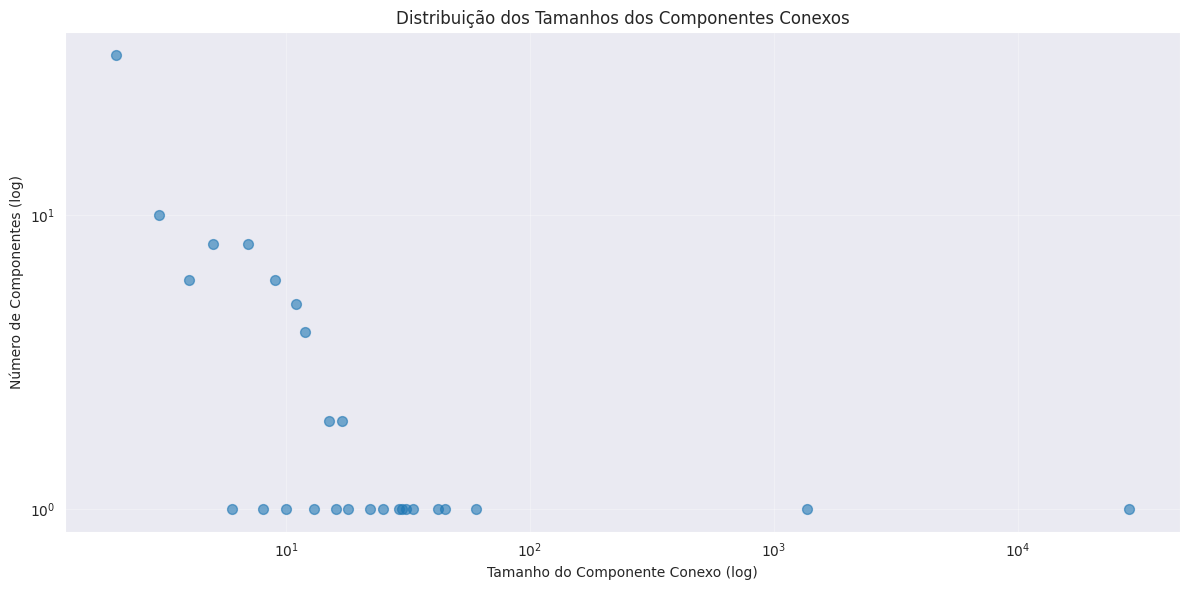

In [ ]:


cc_size_counts = Counter(cc_lengths)

sizes = sorted(cc_size_counts.keys())
counts = [cc_size_counts[size] for size in sizes]

plt.figure(figsize=(12, 6))
plt.scatter(sizes, counts, alpha=0.6, s=50)
plt.xlabel('Tamanho do Componente Conexo (log)')
plt.ylabel('Número de Componentes (log)')

plt.xscale('log')
plt.yscale('log')

plt.title('Distribuição dos Tamanhos dos Componentes Conexos')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 1.3.2. Graus

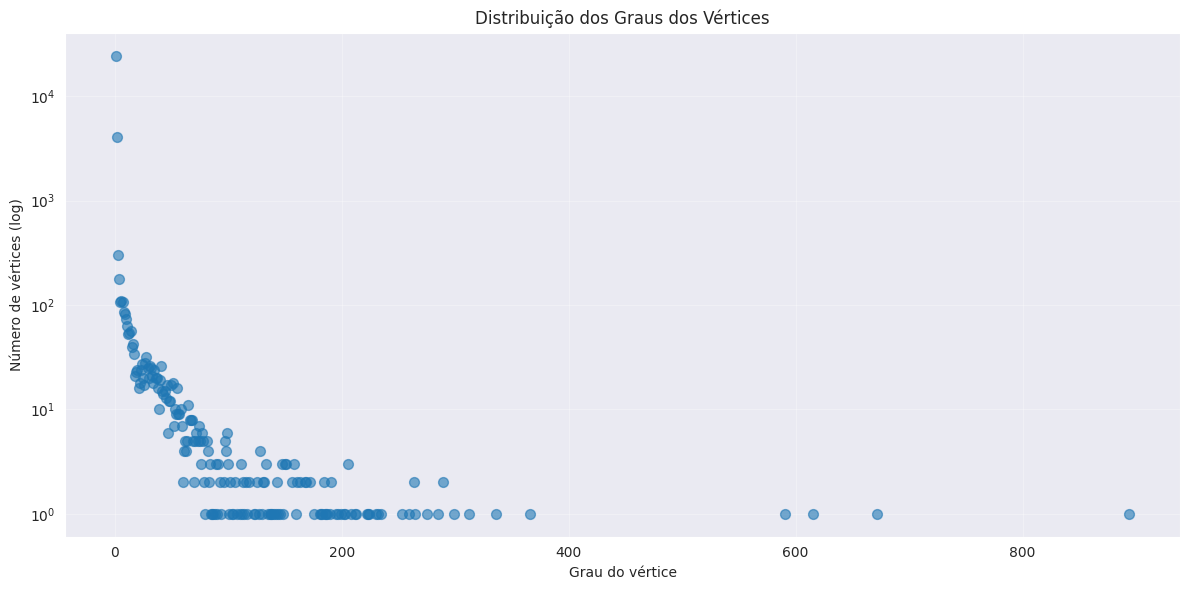

In [87]:
degrees = list(g.degree())



degree_counts = Counter(degrees)

sizes = sorted(degree_counts.keys())
counts = [degree_counts[size] for size in sizes]

plt.figure(figsize=(12, 6))
plt.scatter(sizes, counts, alpha=0.6, s=50)
plt.xlabel('Grau do vértice')
plt.ylabel('Número de vértices (log)')

# plt.xscale('log')
plt.yscale('log')

plt.title('Distribuição dos Graus dos Vértices')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()